## Notebook Contents:

* [1. Libraries](#lib)
* [2. Data Exploration](#exp)
* [3. Data Cleaning](#cleaning)
* [4. Feature Engineering](#fengineering)
* [5. Feature Selection](#selection)
    * [5.1. Mutual Information Classifier](#tech1)
    * [5.2. Recursive Feature Elimination](#tech2)

* [6. Predictive Modelling](#modelling)
    * [6.1. Logistic Regression](#LR)
    * [6.2. Gradient Boosting Classifier](#GBC)
    * [6.3. Neural Networks](#NN)
* [7. Test run](#test)    

<hr>
<a id="lib">

## 1. Libraries
    
</a>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import datetime
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

<hr>
<a id="exp">

## 2. Data Exploration and Pre-processing
    
</a>

In [6]:
raw_data = pd.read_excel('Train.xlsx')
df = raw_data.copy()
df.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [7]:
# df dimensions and proportion of each column type, at this point, the column types were assigned automatically
print(df.shape)
print(df.dtypes.value_counts())

(22400, 15)
object    9
int64     6
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [9]:
# replace "?" by nans
df.replace('?', np.nan, inplace = True)

In [10]:
# Check for missing values
df.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

<hr>
<a id="cleaning">

## 3. Data Cleaning
    
</a>

In [11]:
df['Birthday']=df['Birthday'].map(lambda x:2044 - int(x[-4:]))

In [12]:
df = df.drop(['Education Level'],axis=1)

## Missing Values

In [13]:
metric_features = []
for col in list(df.columns):
    if df[col].dtype!='object':
        metric_features.append(col)
missing = ['Base Area','Employment Sector','Role']
impute = metric_features + missing

In [14]:
#Filling the missing values with the mode of each variable
df['Base Area'].fillna(df['Base Area'].mode(), inplace = True)
df['Role'].fillna(df['Role'].mode(), inplace = True)
df['Employment Sector'].replace(np.nan, '?', inplace = True)
df['Employment Sector'] = df['Employment Sector'].map(lambda x: 'Private Sector - Services' if x== '?' else x)

<hr>
<a id="fengineering">

## 4. Feature Engineering
    
</a>

In [15]:
def gender_binary(x):
    if x=='Mr. ':
        return 1
    else:
        return 0

In [16]:
# Combine 'Married' and 'Married - Spouse in the Army' into a single categorical value
df['Marital Status'] = df['Marital Status'].map(lambda x: x if x != 'Married - Spouse in the Army' else 'Married')

# Combine 'Wife' and 'Husband' into a single categorical value
spouse = ['Wife','Husband']
df['Lives with'] = df['Lives with'].map(lambda x: 'Spouse' if x in spouse else x)

# Combine the discriminated values for both 'Private' and 'Public ' Sectors into a single value - 'Public Sector' and 'Private Sector'
sectors = ['Private','Public ']
df['Employment Sector'] = df['Employment Sector'].map(lambda x: str.strip(x[0:7]) if x[0:7] in sectors else x)

# Turn the columns 'Ticket Price' and 'Money Received' into binary columns
df['Ticket Price'] = df['Ticket Price'].map(lambda x: 1 if x != 0 else 0).astype(object)
df['Money Received'] = df['Money Received'].map(lambda x: 1 if x != 0 else 0).astype(object)

df['Gender'] = df['Name'].map(lambda x: x[0:4])
df['Gender'] = df['Gender'].apply(lambda x: gender_binary(x)).astype(object)
df.drop(columns=['Name'], inplace=True)

df_feature = df.copy()

In [17]:
non_metric_features = []
metric_features = []
for col in list(df.columns):
    if df[col].dtype=='object':
        non_metric_features.append(col)
    else:
        metric_features.append(col)
    
metric_features.remove('CITIZEN_ID')
metric_features.remove('Income')

In [18]:
df_encoded = pd.get_dummies(df[non_metric_features[0:6]])
df_encoded.head()

,Native Continent_Africa,Native Continent_America,Native Continent_Asia,Native Continent_Europe,Native Continent_Oceania,Marital Status_Divorced,Marital Status_Married,Marital Status_Married - Spouse Missing,Marital Status_Separated,Marital Status_Single,...,Role_Household Services,Role_IT,Role_Machine Operators & Inspectors,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [19]:
df = pd.concat([df,df_encoded],axis = 1)
df.head()

,CITIZEN_ID,Birthday,Native Continent,Marital Status,Lives with,Base Area,Years of Education,Employment Sector,Role,Working Hours per week,...,Role_Household Services,Role_IT,Role_Machine Operators & Inspectors,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports
0,12486,41,Europe,Married,Spouse,Northbury,13,Private,Repair & constructions,40,...,0,0,0,0,0,0,1,0,0,0
1,12487,38,Europe,Married,Spouse,Northbury,12,Public,Repair & constructions,40,...,0,0,0,0,0,0,1,0,0,0
2,12488,35,Europe,Married,Spouse,Northbury,12,Private,Sales,46,...,0,0,0,0,0,0,0,1,0,0
3,12489,59,Europe,Married,Spouse,Northbury,11,Private,Security,37,...,0,0,0,0,0,0,0,0,1,0
4,12490,29,Europe,Single,Other Family,Northbury,21,Self-Employed (Individual),Professor,45,...,0,0,0,0,0,1,0,0,0,0


In [20]:
df.drop(non_metric_features[0:6],axis = 1,inplace = True)
df

,CITIZEN_ID,Birthday,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Gender,Native Continent_Africa,Native Continent_America,...,Role_Household Services,Role_IT,Role_Machine Operators & Inspectors,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports
0,12486,41,13,40,0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,12487,38,12,40,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,12488,35,12,46,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,12489,59,11,37,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,12490,29,21,45,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,21,12,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22396,34882,19,12,35,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
22397,34883,22,17,40,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
22398,34884,33,16,90,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


2021-01-07 09:06:27,404 - INFO     - NumExpr defaulting to 8 threads.


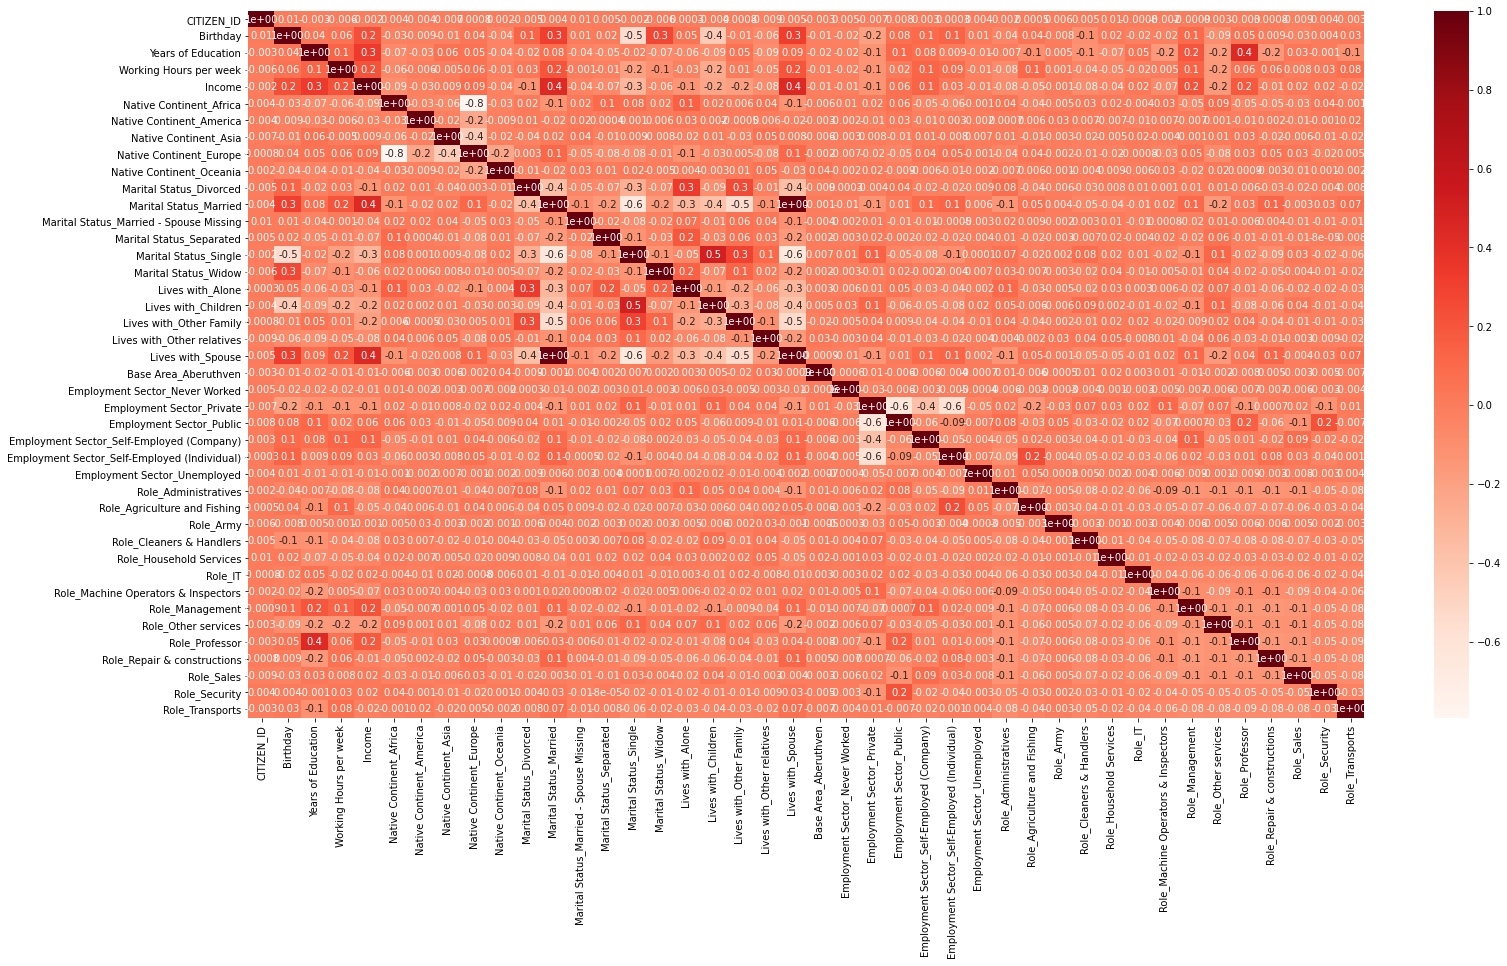

In [21]:
def cor_heatmap(cor):
    plt.figure(figsize=(25,13))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_heatmap(df.drop(columns=['Base Area_Aerilon', 'Base Area_Alverton',
       'Base Area_Aroonshire', 'Base Area_Auchenshuggle', 'Base Area_Bellenau',
       'Base Area_Bellmoral', 'Base Area_Butterpond', 'Base Area_Carlisle',
       'Base Area_Cherrytown', 'Base Area_Conriston', 'Base Area_Drumchapel',
       'Base Area_Eelry', 'Base Area_Fanfoss', "Base Area_Fool's March",
       'Base Area_Ironforge', 'Base Area_Kald', "Base Area_King's Watch",
       'Base Area_Kirkwall', "Base Area_Knife's Edge", 'Base Area_Laenteglos',
       'Base Area_Laewaes', 'Base Area_Lanercost', 'Base Area_Lewes',
       'Base Area_Marnmouth', 'Base Area_Mensfield', 'Base Area_Middlesbrough',
       'Base Area_MillerVille', 'Base Area_Northbury', 'Base Area_Orilon',
       'Base Area_Pran', 'Base Area_Redwick Bush', 'Base Area_Sharnwick',
       'Base Area_Sharpton', 'Base Area_Tranmere', 'Base Area_Watford',
       'Base Area_Wigston', 'Base Area_Willesden', 'Base Area_Woodpine']).corr())

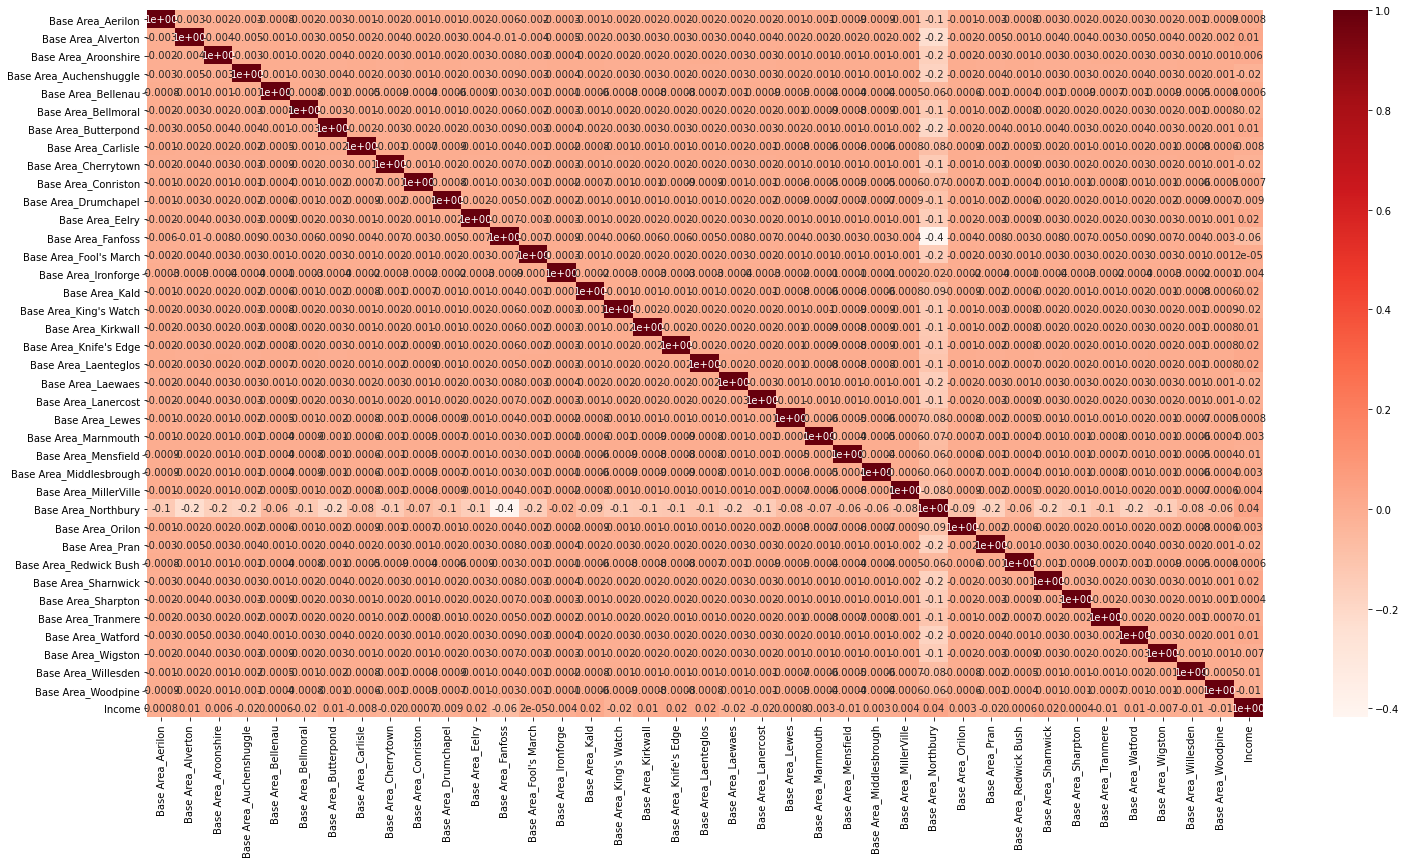

In [22]:
cor_heatmap(df[['Base Area_Aerilon', 'Base Area_Alverton',
       'Base Area_Aroonshire', 'Base Area_Auchenshuggle', 'Base Area_Bellenau',
       'Base Area_Bellmoral', 'Base Area_Butterpond', 'Base Area_Carlisle',
       'Base Area_Cherrytown', 'Base Area_Conriston', 'Base Area_Drumchapel',
       'Base Area_Eelry', 'Base Area_Fanfoss', "Base Area_Fool's March",
       'Base Area_Ironforge', 'Base Area_Kald', "Base Area_King's Watch",
       'Base Area_Kirkwall', "Base Area_Knife's Edge", 'Base Area_Laenteglos',
       'Base Area_Laewaes', 'Base Area_Lanercost', 'Base Area_Lewes',
       'Base Area_Marnmouth', 'Base Area_Mensfield', 'Base Area_Middlesbrough',
       'Base Area_MillerVille', 'Base Area_Northbury', 'Base Area_Orilon',
       'Base Area_Pran', 'Base Area_Redwick Bush', 'Base Area_Sharnwick',
       'Base Area_Sharpton', 'Base Area_Tranmere', 'Base Area_Watford',
       'Base Area_Wigston', 'Base Area_Willesden', 'Base Area_Woodpine','Income']].corr())

In [23]:
df.drop(columns= 'Lives with_Spouse', inplace = True)
df.drop(columns= 'Employment Sector_Never Worked', inplace = True)

<hr>
<a id="selection">

## 5. Feature Selection
    
</a>

In [24]:
def feature_selection(method,X,y, k):
    if method==mutual_info_classif:
        sel_method = SelectKBest(method, k=k)
        sel_method.fit_transform(X, y)
        results = sel_method.get_support()
        keep = []
        for index, hyp in enumerate(results):
            if hyp==True:
                keep.append(X.columns[index])
        return keep
    else:
        model = method()
        sel_method = RFE(estimator=model, n_features_to_select = k)
        sel_method.fit_transform(X, y)
        results = sel_method.get_support()
        keep = []
        for index, hyp in enumerate(results):
            if hyp==True:
                keep.append(X.columns[index])
        return keep

In [25]:
data_ba = df[['Base Area_Aerilon', 'Base Area_Alverton',
       'Base Area_Aroonshire', 'Base Area_Auchenshuggle', 'Base Area_Bellenau',
       'Base Area_Bellmoral', 'Base Area_Butterpond', 'Base Area_Carlisle',
       'Base Area_Cherrytown', 'Base Area_Conriston', 'Base Area_Drumchapel',
       'Base Area_Eelry', 'Base Area_Fanfoss', "Base Area_Fool's March",
       'Base Area_Ironforge', 'Base Area_Kald', "Base Area_King's Watch",
       'Base Area_Kirkwall', "Base Area_Knife's Edge", 'Base Area_Laenteglos',
       'Base Area_Laewaes', 'Base Area_Lanercost', 'Base Area_Lewes',
       'Base Area_Marnmouth', 'Base Area_Mensfield', 'Base Area_Middlesbrough',
       'Base Area_MillerVille', 'Base Area_Northbury', 'Base Area_Orilon',
       'Base Area_Pran', 'Base Area_Redwick Bush', 'Base Area_Sharnwick',
       'Base Area_Sharpton', 'Base Area_Tranmere', 'Base Area_Watford',
       'Base Area_Wigston', 'Base Area_Willesden', 'Base Area_Woodpine']]
target = df['Income']
keep_BA = feature_selection(LogisticRegression, data_ba, target, 5)
drop_BA = []
for col in data_ba.columns.tolist():
    if col not in keep_BA:
        drop_BA.append(col)

In [26]:
data = df[df.columns[1:]].drop('Income', axis=1)
data.drop(columns=drop_BA, inplace=True)
target = df['Income']

<a class="anchor" id="tech1">

## 5.1. MIC

</a>

In [27]:
keep_mic = feature_selection(mutual_info_classif,data, target, 20)

<a class="anchor" id="tech2">

## 5.2. RFE

</a>

In [28]:
keep_RFE = feature_selection(LogisticRegression, data, target, 20)

In [29]:
keep = list(set(keep_RFE + keep_mic))
len(keep)

31

<hr>
<a id="modelling">

## 6. Predictive Modelling
    
</a>

In [30]:
keep += ['Income']

In [31]:
df_model = df[keep]
df_model.head()

,Base Area_Pran,Role_IT,Employment Sector_Private,Role_Agriculture and Fishing,Native Continent_Oceania,Marital Status_Married,Working Hours per week,Money Received,Marital Status_Single,Base Area_Fanfoss,...,Base Area_Cherrytown,Lives with_Other relatives,Role_Security,Lives with_Alone,Base Area_Bellmoral,Role_Cleaners & Handlers,Role_Sales,Marital Status_Divorced,Lives with_Children,Income
0,0,0,1,0,0,1,40,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,40,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,1,46,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,1,37,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,45,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
df_model.columns

Index(['Base Area_Pran', 'Role_IT', 'Employment Sector_Private',
       'Role_Agriculture and Fishing', 'Native Continent_Oceania',
       'Marital Status_Married', 'Working Hours per week', 'Money Received',
       'Marital Status_Single', 'Base Area_Fanfoss', 'Years of Education',
       'Employment Sector_Unemployed', 'Role_Management', 'Ticket Price',
       'Native Continent_Africa', 'Role_Administratives', 'Role_Professor',
       'Role_Other services', 'Lives with_Other Family',
       'Role_Household Services', 'Birthday', 'Gender', 'Base Area_Cherrytown',
       'Lives with_Other relatives', 'Role_Security', 'Lives with_Alone',
       'Base Area_Bellmoral', 'Role_Cleaners & Handlers', 'Role_Sales',
       'Marital Status_Divorced', 'Lives with_Children', 'Income'],
      dtype='object')

Executing shutdown due to inactivity...


2021-01-07 10:01:48,382 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-01-07 10:02:00,572 - INFO     - Executing shutdown...


In [155]:
data =  df_model.drop('Income', axis=1)
target = df_model['Income']
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state=5, stratify=target)

       
metric = ['Birthday', 'Years of Education', 'Working Hours per week']

In [156]:
scaler = StandardScaler()
X_train[metric]  = scaler.fit_transform(X_train[metric])
X_test[metric] = scaler.transform(X_test[metric])

In [157]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                     VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

<a class="anchor" id="LR">

## 6.1. Logistic Regression

</a>

In [158]:
log_model = LogisticRegression()

In [159]:
log_model.fit(X_train,y_train)

LogisticRegression()

In [160]:
y_pred = log_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [161]:
labels_train = log_model.predict(X_train)
labels_val = log_model.predict(X_test)
metrics(y_train = y_train, pred_train = labels_train, y_val = y_test, pred_val = labels_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     13671
           1       0.70      0.56      0.62      4249

    accuracy                           0.84     17920
   macro avg       0.79      0.74      0.76     17920
weighted avg       0.83      0.84      0.83     17920

[[12655  1016]
 [ 1863  2386]]
___________________________________________________________________________________________________________
                                                     VALIDATION                                                 
-------------------------------------------------------------------------------------------------

In [162]:
f1_score(y_test, labels_val, average='micro')

0.8508928571428571

<a class="anchor" id="GBC">

## 6.2. Gradient Boosting Classifier

</a>

In [187]:
gb = GradientBoostingClassifier(min_samples_split=200, min_samples_leaf=100, max_depth = 5, max_features='sqrt',learning_rate=0.2, n_estimators = 80, random_state = 4)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=200,
                           n_estimators=80, random_state=4)

In [188]:
y_pred_gb = gb.predict(X_test)

In [189]:
labels_train = gb.predict(X_train)
metrics(y_train = y_train, pred_train = labels_train, y_val = y_test, pred_val = y_pred_gb)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     13671
           1       0.72      0.61      0.66      4249

    accuracy                           0.85     17920
   macro avg       0.80      0.77      0.78     17920
weighted avg       0.85      0.85      0.85     17920

[[12673   998]
 [ 1648  2601]]
___________________________________________________________________________________________________________
                                                     VALIDATION                                                 
-------------------------------------------------------------------------------------------------

In [190]:
f1_score(y_test, y_pred_gb, average='micro')

0.8566964285714286

<a class="anchor" id="NN">

## 6.3. Neural Networks

</a>

In [191]:
model_NN = MLPClassifier()

In [192]:
model_NN.fit(X_train, y_train)

MLPClassifier()

In [193]:
labels_train = model_NN.predict(X_train)
labels_val = model_NN.predict(X_test)

In [194]:
metrics(y_train, labels_train, y_test, labels_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     13671
           1       0.74      0.66      0.70      4249

    accuracy                           0.86     17920
   macro avg       0.82      0.79      0.81     17920
weighted avg       0.86      0.86      0.86     17920

[[12662  1009]
 [ 1430  2819]]
___________________________________________________________________________________________________________
                                                     VALIDATION                                                 
-------------------------------------------------------------------------------------------------

In [195]:
f1_score(y_test, labels_val, average='micro')

0.8484375

<hr>
<a id="test">

## 7. Test run
    
</a>

In [197]:
test = pd.read_excel('Test.xlsx')
test.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
0,34886,Mr. Dan Kerr,"May 13,2012",Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,40,0,0
1,34887,Miss Olivia Grant,"August 9,2014",Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Professor,36,0,0
2,34888,Mr. Trevor Simpson,"May 23,2020",Europe,Divorced,Other Family,Northbury,Professional School + PostGraduation,13,Private Sector - Services,Management,50,12940,0
3,34889,Mr. David Clark,"April 15,2016",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Professor,48,0,1827
4,34890,Mr. Gavin Lambert,"April 22,2011",Europe,Married,Wife,Watford,Bachelors,15,Public Sector - Others,Professor,45,0,0


In [198]:
test.replace('?', np.nan, inplace = True)

In [199]:
test = test.drop(['Education Level'],axis=1)

In [200]:
test['Base Area'].fillna(test['Base Area'].mode(), inplace = True)
test['Role'].fillna(test['Role'].mode(), inplace = True)
test['Employment Sector'].replace(np.nan, '?', inplace = True)
test['Employment Sector'] = test['Employment Sector'].map(lambda x: 'Private Sector - Services' if x== '?' else x)

In [201]:
test['Birthday']=test['Birthday'].map(lambda x:2044 - int(x[-4:]))

# Combine 'Married' and 'Married - Spouse in the Army' into a single categorical value
test['Marital Status'] = test['Marital Status'].map(lambda x: x if x != 'Married - Spouse in the Army' else 'Married')

# Combine 'Wife' and 'Husband' into a single categorical value
spouse = ['Wife','Husband']
test['Lives with'] = test['Lives with'].map(lambda x: 'Spouse' if x in spouse else x)

# # Combine the discriminated values for both 'Private' and 'Public ' Sectors into a single value - 'Public Sector' and 'Private Sector'
sectors = ['Private','Public ']
test['Employment Sector'] = test['Employment Sector'].map(lambda x: str.strip(x[0:7]) if x[0:7] in sectors else x)


# Turn the columns 'Ticket Price' and 'Money Received' into binary columns
test['Ticket Price'] = test['Ticket Price'].map(lambda x: 1 if x != 0 else 0).astype(object)
test['Money Received'] = test['Money Received'].map(lambda x: 1 if x != 0 else 0).astype(object)

test['Gender'] = test['Name'].map(lambda x: x[0:4])
test['Gender'] = test['Gender'].apply(lambda x: gender_binary(x)).astype(object)
test.drop(columns=['Name'], inplace=True)

In [202]:
non_metric_features = []
metric_features = []
for col in list(test.columns):
    if test[col].dtype=='object':
        non_metric_features.append(col)
    else:
        metric_features.append(col)
    
metric_features.remove('CITIZEN_ID')

In [203]:
df_encoded = pd.get_dummies(test[non_metric_features[0:6]])
df_encoded.head()

,Native Continent_Africa,Native Continent_America,Native Continent_Asia,Native Continent_Europe,Native Continent_Oceania,Marital Status_Divorced,Marital Status_Married,Marital Status_Married - Spouse Missing,Marital Status_Separated,Marital Status_Single,...,Role_Household Services,Role_IT,Role_Machine Operators & Inspectors,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [204]:
test = pd.concat([test,df_encoded],axis = 1)
test.head()

,CITIZEN_ID,Birthday,Native Continent,Marital Status,Lives with,Base Area,Years of Education,Employment Sector,Role,Working Hours per week,...,Role_Household Services,Role_IT,Role_Machine Operators & Inspectors,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports
0,34886,32,Europe,Married,Spouse,Northbury,16,Private,Sales,40,...,0,0,0,0,0,0,0,1,0,0
1,34887,30,Europe,Single,Other Family,Northbury,16,Private,Professor,36,...,0,0,0,0,0,1,0,0,0,0
2,34888,24,Europe,Divorced,Other Family,Northbury,13,Private,Management,50,...,0,0,0,1,0,0,0,0,0,0
3,34889,28,Europe,Married,Spouse,Northbury,12,Private,Professor,48,...,0,0,0,0,0,1,0,0,0,0
4,34890,33,Europe,Married,Spouse,Watford,15,Public,Professor,45,...,0,0,0,0,0,1,0,0,0,0


In [205]:
test.drop(non_metric_features[0:6],axis = 1,inplace = True)
test.drop(columns= 'Lives with_Spouse', inplace = True)

In [206]:
keep.remove('Income')

In [207]:
df_model = test[keep]
metric = ['Birthday', 'Years of Education', 'Working Hours per week']
df_model.head()

,Marital Status_Single,Marital Status_Married,Base Area_Bellmoral,Base Area_Fanfoss,Base Area_Pran,Role_Sales,Native Continent_Europe,Lives with_Other relatives,Role_Professor,Role_Household Services,...,Employment Sector_Private,Birthday,Lives with_Children,Employment Sector_Self-Employed (Company),Role_Management,Money Received,Role_Security,Employment Sector_Unemployed,Role_Agriculture and Fishing,Role_IT
0,0,1,0,0,0,1,1,0,0,0,...,1,32,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,1,0,...,1,30,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,24,0,0,1,1,0,0,0,0
3,0,1,0,0,0,0,1,0,1,0,...,1,28,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,1,0,...,0,33,0,0,0,0,0,0,0,0


In [208]:
df_model[metric]  = scaler.transform(test[metric])

In [209]:
y_pred = gb.predict(df_model)
y_pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [210]:
Income = pd.DataFrame(y_pred)

In [211]:
results = pd.concat([test['CITIZEN_ID'],Income],axis = 1)
results.set_index('CITIZEN_ID', inplace=True)

In [212]:
results.columns=['Income']

In [213]:
results.to_csv('group34.csv')